In [164]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.tsa.stattools import coint
from statsmodels.regression.linear_model import OLS
import scipy.stats as scs
import statsmodels.api as sm
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as datetime
import itertools
from itertools import product
from bayes_opt import BayesianOptimization
import yfinance as yf
from scipy.stats import skew, kurtosis
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import MACD
from ta.volume import OnBalanceVolumeIndicator
from ta.volume import AccDistIndexIndicator
from statsmodels.tsa.stattools import acf
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import make_scorer

In [11]:
import os
import json
import pickle
os.chdir('/Users/selena/Desktop/QF2103/Project')
pd.set_option('future.no_silent_downcasting', True)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/selena/Desktop/QF2103/Project'

## load the saved dataframes and dictionaries 

In [166]:
def convert_string_keys_to_tuples(d):
    return {tuple(key.split('-')): value for key, value in d.items()}

# Load the JSON file
with open('pair_strats_best_params.json', 'r') as f:
    loaded_pair_strats_best_params = json.load(f)

with open('others_strats_best_params.json', 'r') as f:
    loaded_other_strats_best_params = json.load(f)

# convert string keys back to tuples
pair_strats_best_params_tuple_keys = {
    outer_key: convert_string_keys_to_tuples(inner_dict)
    for outer_key, inner_dict in loaded_pair_strats_best_params.items()
}


# load individual dictionaries
test_pairs_all_best_params = pair_strats_best_params_tuple_keys['test_pairs_all_best_params']
pairs_all_best_params = pair_strats_best_params_tuple_keys['pairs_all_best_params']
test_bollinger_all_best_params = loaded_other_strats_best_params['test_bollinger_all_best_params']
bollinger_all_best_params = loaded_other_strats_best_params['bollinger_all_best_params']
test_sma_all_best_params = loaded_other_strats_best_params['test_sma_all_best_params']
sma_all_best_params = loaded_other_strats_best_params['sma_all_best_params']

# load DataFrames
test_benchmark_strat_df = pd.read_pickle('test_benchmark_strat_df.pkl')
benchmark_strat_df = pd.read_pickle('benchmark_strat_df.pkl')
test_otpimized_pairs_strat_df = pd.read_pickle('test_otpimized_pairs_strat_df.pkl')
otpimized_pairs_strat_df = pd.read_pickle('otpimized_pairs_strat_df.pkl')
test_otpimized_bollinger_stocks_df = pd.read_pickle('test_otpimized_bollinger_stocks_df.pkl')
otpimized_bollinger_stocks_df = pd.read_pickle('otpimized_bollinger_stocks_df.pkl')
test_otpimized_sma_stocks_df = pd.read_pickle('test_otpimized_sma_stocks_df.pkl')
otpimized_sma_stocks_df = pd.read_pickle('otpimized_sma_stocks_df.pkl')

## data cleaning

In [30]:
def clean_data(file):
    raw = pd.read_csv(file, header=1, index_col=0)
    data = raw.iloc[1:, :].copy()
    # reformat and clean dataset
    data.rename_axis("Date", inplace=True)
    data.index = pd.to_datetime(data.index, format="%d/%m/%Y")
    
    data.dropna(inplace=True) # last 2 rows NaN values dropped
    # rename all columns according to metrics
    metrics = ["Close", "Dividends", "High", "Low", "Open", "Stock Splits", "Volume"]
    columns = data.columns
    new_columns = {}
    for col in columns:
      if '.' in col:
        stock, suffix = col.split('.')
        metric_index = int(suffix)
        new_columns[col] = f"{stock}_{metrics[metric_index]}"
      else:
        new_columns[col] = f"{col}_Close"
    data.rename(columns=new_columns, inplace=True)
    return data


def benchmark_strategy(data, stock, rf = 0.04):
    df = pd.DataFrame(index=data.index, columns=['Returns', 'Cumulative Returns'])
    df['Returns'] = np.log(data[stock]/data[stock].shift(1)).fillna(0)
    df['Cumulative Returns'] = df['Returns'].cumsum()
    total_return = np.exp(df['Cumulative Returns'].iloc[-1]) - 1
    annualized_return = np.mean((np.exp(df['Returns']) - 1)) * 252
    daily_volatility = np.std(df['Returns'])
    annualized_volatility = daily_volatility * np.sqrt(252)
    sharpe_ratio = np.where(annualized_volatility != 0,
                        (annualized_return - rf) / annualized_volatility,
                        0)

    metrics = {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio}
    
    return metrics, df

## Trading period data (17 Jan 2024 to 16 January 2025)

In [33]:
file = 'Trading_Project_Data.csv'
data = clean_data(file).iloc[:, :20].copy() # extract close prices from cleaned data
data = data.loc['2024-03-01':] # trading period data
stocks = list(set([col.split("_")[0] for col in data.columns]))
stocks.sort()
for stock in stocks:
    data.rename(columns={f'{stock}_Close': f'{stock}'}, inplace=True)

## Testing data (17 Jan 2023 to 16 January 2024)

In [179]:
# 1 year before testing data
test = yf.Tickers(stocks)
test_data = test.history(start = '2023-01-17', end = '2024-01-17') # dates edited again for training, slice out appropriate window
columns_to_drop = ['High', 'Low', 'Open', 'Dividends', 'Stock Splits'] # do not drop volume
test_data.drop(columns=columns_to_drop, inplace=True)
# test_data = test_data.swaplevel(0,1,axis=1).sort_index(axis=1)
test_vol = test_data.iloc[:,-20:].copy()
test_vol.columns = test_vol.columns.droplevel(0)

test_data = test_data.iloc[:,:20].copy()
test_data.columns = test_data.columns.droplevel(0)

[*********************100%***********************]  20 of 20 completed


## pairs trading strategy

In [182]:
def cointegration_test(data, threshold):
    stock_pairs = itertools.combinations(data.columns, 2) # get all pairs of stocks
    cointegrated_pairs = []
    p_values = []

    for stock1, stock2 in stock_pairs:
        X = sm.add_constant(data[stock1]) # regress stock2 (DV) on stock1 (IV)
        model = OLS(data[stock2], X).fit()
        residuals = data[stock2] - model.predict() # errors from regression (spread)
        # test residuals for stationarity using a unit root test -> Augmented Dickey-Fuller test
        adf_test = adfuller(residuals)
        p_value = adf_test[1]
        if p_value < threshold: # residuals are stationary, stock1 and stock2 are cointegrated
            cointegrated_pairs.append((stock1, stock2))
            p_values.append(p_value)
            
    return cointegrated_pairs, p_values


def pairs_strat(data, pair, window, entry_threshold, exit_threshold, rf=0.04):
    stock1, stock2 = pair
    
    # compute zscore for the pair
    X = sm.add_constant(data[stock1])
    model = sm.OLS(data[stock2], X).fit()
    spread = data[stock2] - model.predict(X) # calculate the spread as residuals
    # rolling mean and std of spread
    spread_mean = spread.rolling(window=window).mean()
    spread_std = spread.rolling(window=window).std()
    zscore = (spread - spread_mean) / spread_std
    zscore = zscore.fillna(0)

    # apply pairs trading strat
    # initialise DataFrame to store positions and returns for the pair
    pair_df = pd.DataFrame(index=zscore.index, columns=[f'{stock1} Position', f'{stock2} Position', f'{stock1} Returns', f'{stock2} Returns'])

    # initialise positions and returns as 0 both for stocks for the start
    pair_df.iloc[:, :] = 0


    # generate daily entry and exit signals (positions)
    for i in pair_df.index[1:]:
        current_zscore = zscore.loc[i]
            
        # zscore < -entry_threshold and no existing long position for stock 1
        if (current_zscore < -entry_threshold) & (pair_df[f'{stock1} Position'].shift(1).at[i] == 0):
            pair_df.loc[i, f'{stock1} Position'] = 1  # long stock 1
            pair_df.loc[i, f'{stock2} Position'] = -0.5 # short stock 2

        # zscore > entry_threshold and no existing short position for stock 2
        elif (current_zscore > entry_threshold) & (pair_df[f'{stock2} Position'].shift(1).at[i] == 0):
            pair_df.loc[i, f'{stock1} Position'] = -0.5  # short stock 1
            pair_df.loc[i, f'{stock2} Position'] = 1   # long stock 2

        # -exit_threshold < zscore < exit_threshold

        elif abs(current_zscore) < exit_threshold:
            pair_df.loc[i, f'{stock1} Position'] = 0  # exit position in stock 1
            pair_df.loc[i, f'{stock2} Position'] = 0  # exit position in stock 2
    

        # -entry_threshold < zscore < -exit_threshold or exit_threshold < zscore < entry_threshold
        else:
            pair_df.loc[i, f'{stock1} Position'] = pair_df[f'{stock1} Position'].shift(1).at[i] # maintain existing position in stock 1
            pair_df.loc[i, f'{stock2} Position'] = pair_df[f'{stock2} Position'].shift(1).at[i] # maintain existing position in stock 2


        # calculate daily (log) returns for each stock based on the positions
        pair_df.loc[i, f'{stock1} Returns'] = (np.log(data.loc[i, stock1] / data[stock1].shift(1).at[i])) * pair_df[f'{stock1} Position'].shift(1).loc[i]
        pair_df.loc[i, f'{stock2} Returns'] = (np.log(data.loc[i, stock2] / data[stock2].shift(1).at[i])) * pair_df[f'{stock2} Position'].shift(1).loc[i]

    if pair_df.empty or len(pair_df) < window:
        return {'total_return': 0, 'other_metrics': None}, pair_df
        
    # calculate combined (log) return, (log) cumulative return and total (simple) return
    pair_df['combined_returns'] =  pair_df[f'{stock1} Returns'] + pair_df[f'{stock2} Returns']
    pair_df['combined_returns'] = pair_df['combined_returns'].astype(float)
    pair_df['cumulative_combined_returns'] = pair_df['combined_returns'].cumsum()
    total_return = np.exp(pair_df['cumulative_combined_returns'].iloc[-1]) - 1
    annualized_return = np.mean((np.exp(pair_df['combined_returns']) - 1)) * 252
    daily_volatility = np.std(pair_df['combined_returns'])
    annualized_volatility = daily_volatility * np.sqrt(252)

    sharpe_ratio = np.where(annualized_volatility != 0,
                        (annualized_return - rf) / annualized_volatility,
                        0)

    metrics = {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio}
    
    return metrics, pair_df


def plot_pairs(data, pair_df, pair, entry_threshold, exit_threshold):
    stock1, stock2 = pair
    

    stock1_log_rets = np.log(data[stock1] / data[stock1].shift(1)).fillna(0)
    stock2_log_rets = np.log(data[stock2] / data[stock2].shift(1)).fillna(0)
    
    # plot (simple) cumulative returns 
    np.exp(pair_df['cumulative_combined_returns']).plot()
    plt.title(f'Cumulative returns for {stock1}-{stock2} pairs')
    plt.plot(np.exp(stock1_log_rets.cumsum()), label=f'{stock1} Benchmark')
    plt.plot(np.exp(stock2_log_rets.cumsum()), label=f'{stock2} Benchmark')
    plt.legend()
    plt.show()


# find parameters values for window, entry and exit for pairs strat that maximises the total returns of the strat (for each pair)
def pairs_bayes_opt(data, pair, window_range = (5, 50), entry_range=(1.5, 3), exit_range=(0, 1), init_points = 5, n_iter = 50):
    pbounds = {'window': window_range, 'entry_threshold': entry_range, 'exit_threshold': exit_range}
    
    def objective(window, entry_threshold, exit_threshold):
        metrics, _ = pairs_strat(data, pair, window=int(window), entry_threshold=entry_threshold, exit_threshold=exit_threshold)
        return metrics['total_return']

    # perform bayes opt
    optimizer = BayesianOptimization(f=objective, # target function to maximise
                                     pbounds=pbounds, # params bounds
                                     random_state=42)
    
    # optimize the params
    optimizer.maximize(init_points=init_points, n_iter=n_iter)
    
    # extract optimized params and total return
    best_window = int(optimizer.max['params']['window']) # round to integer
    best_entry = optimizer.max['params']['entry_threshold']
    best_exit = optimizer.max['params']['exit_threshold']
    best_total_return = optimizer.max['target']
    
    return best_window, best_entry, best_exit, best_total_return

## bollinger bands strategy

In [185]:
def bollinger_bands_strat(data, stock, std, window, rf=0.04):
    stock_df = data[[f'{stock}']].copy()
    stock_df.rename(columns={f'{stock}': 'Close'}, inplace=True)

    # calculate log returns
    stock_df['Returns'] = np.log(stock_df['Close'] / stock_df['Close'].shift(1)).fillna(0)
    
    # calculate SMA and rolling std on close price
    stock_df['SMA'] = stock_df['Close'].rolling(window=window).mean()
    stock_df['STD'] = stock_df['Close'].rolling(window=window).std()
    stock_df = stock_df.fillna(0)

    # calculate the upper and lower bollinger bands
    stock_df['UB'] = stock_df['SMA'] + (stock_df['STD'] * std)
    stock_df['LB'] = stock_df['SMA'] - (stock_df['STD'] * std)
        
    # calculate the position (buy and sell signals)
    stock_df['Position'] = np.where(stock_df['Close'] > stock_df['UB'], -0.5, 
                                    np.where(stock_df['Close'] < stock_df['LB'], 1, 0))
    # calculate strategy returns
    stock_df['Strat_Returns'] = stock_df['Returns'] * stock_df['Position'].shift(1)
    stock_df['Strat_Returns'] = stock_df['Strat_Returns'].fillna(0)

    # total simple return
    total_return = np.exp(stock_df['Strat_Returns'].sum()) - 1


    annualized_return = np.mean(np.exp(stock_df['Strat_Returns']) - 1) * 252
    daily_volatility = np.std(np.exp(stock_df['Strat_Returns']) - 1)
    annualized_volatility = daily_volatility * np.sqrt(252)
    sharpe_ratio = np.where(annualized_volatility != 0,
                        (annualized_return - rf) / annualized_volatility,
                        0)

    metrics = {

        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio}
    
    return metrics, stock_df


def plot_bollinger(stock_df, stock):
    # Plot the (simple) cumulative returns of the strategy compared to the benchmark
    plt.figure(figsize=(12, 6))
    plt.plot(np.exp(stock_df['Strat_Returns'].cumsum()), label='Mean Reversion Strategy')
    plt.plot(np.exp(stock_df['Returns'].cumsum()), label='Benchmark')
    plt.legend()
    plt.title(f'{stock} Cumulative Simple Returns')
    plt.show()

    # trading actions
    # entry signals
    stock_df['Entry_Long'] = (stock_df['Position'].shift(1) == 0) & (stock_df['Position'] == 1) # 0 -> 1
    stock_df['Entry_Short'] = (stock_df['Position'].shift(1) == 0) & (stock_df['Position'] == -0.5)  # 0 -> -0.5
    # exit Signals
    stock_df['Exit_Long'] = (stock_df['Position'].shift(1) == 1) & (stock_df['Position'] == 0)  # 1 -> 0
    stock_df['Exit_Short'] = (stock_df['Position'].shift(1) == -0.5) & (stock_df['Position'] == 0)  # -0.5 -> 0

    # plot close price series, SMA, bollinger bands and trading actions
    plt.figure(figsize=(12, 6))
    plt.plot(stock_df['UB'], label = 'UB', color = 'black')
    plt.plot(stock_df['LB'], label = 'LB', color = 'black')
    plt.plot(stock_df['Close'], label = 'Close', color = 'blue')
    plt.plot(stock_df[stock_df.Entry_Long].index, stock_df['LB'][stock_df.Entry_Long], '^', color = 'g', label = 'Buy Signal', markersize = 8)
    plt.plot(stock_df[stock_df.Entry_Short].index, stock_df['UB'][stock_df.Entry_Short], 'v', color = 'r', label = 'Sell Signal', markersize = 8)
    plt.plot(stock_df[stock_df.Exit_Long].index, stock_df['LB'][stock_df.Exit_Long], 'x', color = 'g', label = 'Exit Long', markersize = 8)
    plt.plot(stock_df[stock_df.Exit_Short].index, stock_df['UB'][stock_df.Exit_Short], 'x'
, color = 'r', label = 'Exit Short', markersize = 8)
    plt.title(f'{stock} Bollinger Bands with Trading Actions')
    plt.legend(loc=1)
    plt.show()


# find parameters values for std and window for bollinger bands strat that maximises the total returns of the strat (for each stock)
def bollinger_bayes_opt(data, stock, std_range=(1.0, 3.5), window_range=(10, 50), init_points = 5, n_iter = 20):
    # bounds for the params in the opt process
    pbounds = {'std': std_range, 'window': window_range}

    def objective(std, window): # objective function for bayes opt
        metrics, _ = bollinger_bands_strat(data, stock, std, int(window))
        return metrics['total_return']

    # perform bayes opt
    optimizer = BayesianOptimization(f=objective,  # target function to maximise
                                     pbounds=pbounds,  # params bounds
                                     random_state=42)

    # optimize the params
    optimizer.maximize(init_points=init_points, n_iter=n_iter)
    
    # extract optimized params and total return
    best_std = optimizer.max['params']['std']
    best_window = int(optimizer.max['params']['window'])  # round to integer
    best_total_return = optimizer.max['target']
    
    return best_std, best_window, best_total_return

## SMA strategy

In [188]:
def sma_strat(data, stock, short_window, long_window, rf=0.04):
    stock_df = data[[f'{stock}']].copy()
    stock_df.rename(columns={f'{stock}': 'Close'}, inplace=True)
    stock_df = data[[stock]].copy()

    # calculate daily log returns
    stock_df['Log_Returns'] = np.log(stock_df[stock] / stock_df[stock].shift(1))

    # calculate moving averages
    stock_df['Short_SMA'] = stock_df[stock].rolling(window=short_window).mean()
    stock_df['Long_SMA'] = stock_df[stock].rolling(window=long_window).mean()
    stock_df = stock_df.fillna(0)

    # generate signals: 1 for long, -1 for short, 0 for no position
    stock_df['Signal'] = np.where(stock_df['Short_SMA'] > stock_df['Long_SMA'], 1, 0)
    stock_df['Signal'] = np.where(stock_df['Short_SMA'] < stock_df['Long_SMA'], -0.5, stock_df['Signal'])

    # detect when a trade occurs (position change)
    stock_df['Trade'] = stock_df['Signal'].diff().fillna(0).abs() > 0

    # calculate strategy returns
    stock_df['SMA_Returns'] = stock_df['Log_Returns'] * stock_df['Signal'].shift(1)
    stock_df['SMA_Returns'] = stock_df['SMA_Returns'].fillna(0)

    # total simple return
    total_return = np.exp(stock_df['SMA_Returns'].sum()) - 1

    # performance metrics
    annualized_return = np.mean(np.exp(stock_df['SMA_Returns']) - 1) * 252
    daily_volatility = np.std(np.exp(stock_df['SMA_Returns']) - 1)
    annualized_volatility = daily_volatility * np.sqrt(252)
    sharpe_ratio = np.where(annualized_volatility != 0,

                        (annualized_return - rf) / annualized_volatility,
                        0)

    metrics = {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio}

    return metrics, stock_df


def plot_sma(stock_df, stock):
    # plot stock price series, SMAs, trading actions
    plt.rcParams['figure.figsize'] = 12, 6
    plt.grid(True, alpha = .3)
    plt.plot(stock_df[stock], label = f'{stock}')
    plt.plot(stock_df['Short_SMA'], label = 'Short_SMA')
    plt.plot(stock_df['Long_SMA'], label = 'Long_SMA')
    plt.plot(stock_df[stock_df.Action == 2].index, stock_df['Short_SMA'][stock_df.Action == 2], '^', color = 'g', markersize = 12)
    plt.plot(stock_df[stock_df.Action == -1].index, stock_df['Short_SMA'][stock_df.Action == -2], 'v', color = 'r', markersize = 12)
    plt.legend(loc=1)
    plt.show()

    # plot cumulative returns (comparison with benchmark strategy (buy and hold)
    plt.plot(stock_df.index, np.exp(stock_df['SMA_Returns'].cumsum()), label= 'SMA Strategy')
    plt.plot(stock_df.index, np.exp(stock_df['Log_Returns'].cumsum()), label='Benchmark (Buy & Hold) Strategy')
    plt.title(f'{stock} Cumulative Returns: SMA Strategy vs Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.show()


# find parameters values for short and long window size for SMA strat that maximises returns for each stock
def sma_bayes_opt(data, stock, short_range=(5, 50), long_range=(51, 200), init_points = 5, n_iter = 50):
    # bounds for the params in the opt process
    pbounds = {'short_window': short_range, 'long_window': long_range}

    def objective(short_window, long_window): # objective function for bayes opt
        metrics, _ = sma_strat(data, stock, int(short_window), int(long_window))
        return metrics['total_return']

    # perform bayes opt
    optimizer = BayesianOptimization(f=objective,  # target function to maximise
                                     pbounds=pbounds,  # params bounds
                                     random_state=42)

    # optimize the params
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

    # extract optimized params and total return
    best_short = int(optimizer.max['params']['short_window']) # round to integer
    best_long = int(optimizer.max['params']['long_window'])  # round to integer
    best_total_return = optimizer.max['target']

    return best_short, best_long, best_total_return

## linear regression strategy

In [191]:
volume = clean_data(file).iloc[:,-20:].copy()
volume.columns = stocks

In [193]:
def compute_indicators(data, volume, stock):
    close = data[[stock]].copy()
    close.columns = ['Close']
    close['Volume'] = volume[stock].copy()
    close['Return'] = close['Close'].pct_change()
    close['Log_Returns'] = np.log(close['Close']/close['Close'].shift())
    close['Volume_Lag'] = close['Volume'].shift()
    close.fillna(0, inplace=True)
    close['SMA_10'] = close['Close'].rolling(window=10).mean().shift()
    close['SMA_20'] = close['Close'].rolling(window=20).mean().shift()
    close['EMA_5'] = close['Close'].ewm(min_periods = 12, alpha = 0.7,adjust=False).mean().shift()
    close['RSI'] = RSIIndicator(close['Close'], window=14).rsi().shift()
    close['MACD'] = (close['Close'].ewm(span=12, adjust=False).mean() - close['Close'].ewm(span=26, adjust=False).mean()).shift()
    close['BB_High'] = BollingerBands(close['Close']).bollinger_hband().shift()
    close['BB_Low'] = BollingerBands(close['Close']).bollinger_lband().shift()
    close['Bollinger_Width'] = BollingerBands(close['Close']).bollinger_wband().shift()
    close['Volatility'] = close['Log_Returns'].rolling(window=5).std().shift()
    close['Skewness'] = close['Log_Returns'].rolling(window=5).apply(skew, raw= True).shift()
    close['Kurtosis'] = close['Log_Returns'].rolling(window=5).apply(kurtosis, raw= True).shift()
    close['OBV'] = OnBalanceVolumeIndicator(close['Close'], close['Volume']).on_balance_volume().shift()

    
    # target
    close['Direction'] = np.sign(close['Log_Returns']).astype(int)
    return close

def create_lags(stock):
    # Create lagged features
    num_lags = 20  # Test different values
    for i in range(1, num_lags + 1):
        stock[f'Lag_{i}'] = stock['Log_Returns'].shift(i)

    stock.dropna(inplace=True)  # Drop NaN values
    
def select_lags_logreg(stock, num_lags):
    
    X = stock[[f'Lag_{i}' for i in range(1, num_lags + 1)]]
    y = stock['Direction']  # Binary direction (1 = up, 0 = down)

    # Recursive Feature Elimination
    model = LogisticRegression(random_state=42)
    selector = RFE(model, n_features_to_select=5)
    selector.fit(X, y)

    selected_features = [f'Lag_{i}' for i, selected in enumerate(selector.support_, 1) if selected]
    print("Selected Lags:", selected_features)
    return selected_features


def sliding_window_linear_reg(df, train_data, features, train_size=63, test_size=21):
    # Uses 3-month training window to predict the next month, retrains the model every month
    predictions = []
    r2_scores = []  # Store R-squared scores
    
    current_data = train_data.copy()
    
    for i in range(0, len(df), test_size):
        # Define training and testing data
        test_data = df.iloc[i:i + test_size]
        
        # Initialize scalers for training and test data
        train_scaler = MinMaxScaler()
        test_scaler = MinMaxScaler()
        
        # Scale the training data
        scaled_data = train_scaler.fit_transform(current_data[features])
        # Scale the test data using the training scaler
        test_scaler.fit(current_data[features])
        scaled_test = test_scaler.transform(test_data[features])
        
        # Split the training and testing data
        X_train = scaled_data
        y_train = current_data['Log_Returns']  # Use 'Log_Returns' for continuous target variable
        X_test = scaled_test
        y_test = test_data['Log_Returns']  # Same for the test set
        
        # Initialize the Linear Regression model
        model = LinearRegression()
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        # Calculate the R-squared score
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)
        
        # Add predictions txo the list
        predictions.extend(y_pred)
        
        # Update the current data for the next iteration
        current_data = pd.concat((current_data, test_data))
        if len(current_data) > train_size:
            current_data = current_data.iloc[len(current_data) - train_size:]
        
        # Dynamically update the features used (based on selected lags)
        # features = ['SMA_10', 'EMA_5', 'Volatility', 'Skewness', 'Kurtosis'] + select_lags_logreg(current_data, 20)
    predictions = np.array(predictions)
    predictions = np.where(predictions < np.percentile(predictions, 10), -0.5, 1)
    return predictions, r2_scores


def get_ret(data, volume, ticker, train_end, test_start, sliding_window_strat, features = ['SMA_10', 'EMA_5', 'Volatility', 'Skewness', 'Kurtosis', 'Lag_1', 'Lag_2', 'Lag_4', 'Lag_8', 'Lag_16']):
    print(ticker)
    stock = compute_indicators(data, volume, ticker)
    create_lags(stock)
    train = stock.loc[:train_end].copy()
    test = stock.loc[test_start:].copy()
    
    pred, acc = sliding_window_strat(test, train, features)
    test['Returns_LinReg'] = (pred* test['Log_Returns'])

    print(test[['Log_Returns','Returns_LinReg']].sum().apply(np.exp))
    print('\n')
    test[['Log_Returns','Returns_LinReg']].cumsum().apply(np.exp).plot()
    return test['Returns_LinReg'], np.mean(acc)

def get_results(data, volume, start, end, strat, features):
    res = pd.DataFrame()
    acc_res = pd.DataFrame()
    for ticker in stocks:
        ret, mean_acc = get_ret(data, volume, ticker,start, end, strat, features)
        res[ticker] = ret
        acc_res[ticker] = np.array([mean_acc])
    return res, acc_res

In [195]:
features = ['EMA_5', 'RSI', 'MACD', 'OBV', 'Lag_1','Lag_2','Lag_3','Lag_4','Lag_5']

### testing window

AAPL
Log_Returns       1.250763
Returns_LinReg    1.072417
dtype: float64


AMZN
Log_Returns       1.625385
Returns_LinReg    1.603104
dtype: float64


BA
Log_Returns       0.994890
Returns_LinReg    0.998949
dtype: float64


CAT
Log_Returns       1.217779
Returns_LinReg    1.480431
dtype: float64


CVX
Log_Returns       0.920738
Returns_LinReg    0.884797
dtype: float64


GOOGL
Log_Returns       1.582168
Returns_LinReg    1.437311
dtype: float64


GS
Log_Returns       1.116189
Returns_LinReg    1.252636
dtype: float64


JNJ
Log_Returns       1.071447
Returns_LinReg    1.117750
dtype: float64


JPM
Log_Returns       1.205357
Returns_LinReg    1.343861
dtype: float64


KO
Log_Returns       1.039870
Returns_LinReg    0.976543
dtype: float64


MCD
Log_Returns       1.121486
Returns_LinReg    1.047531
dtype: float64


MSFT
Log_Returns       1.574640
Returns_LinReg    1.322453
dtype: float64


NKE
Log_Returns       0.867370
Returns_LinReg    1.035588
dtype: float64


NVDA
Log_Returns       

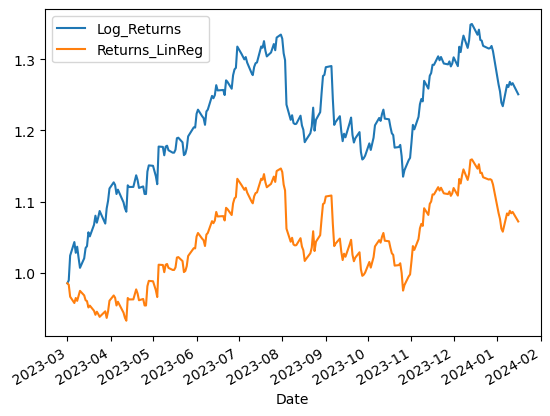

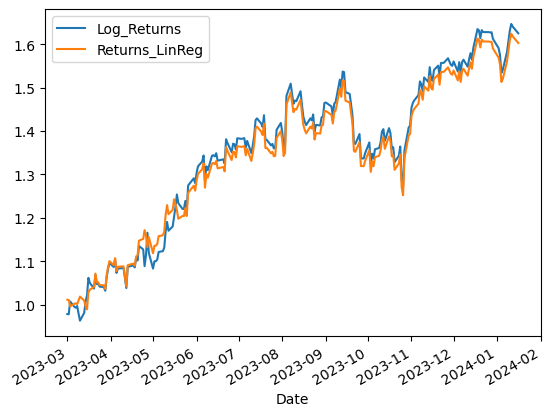

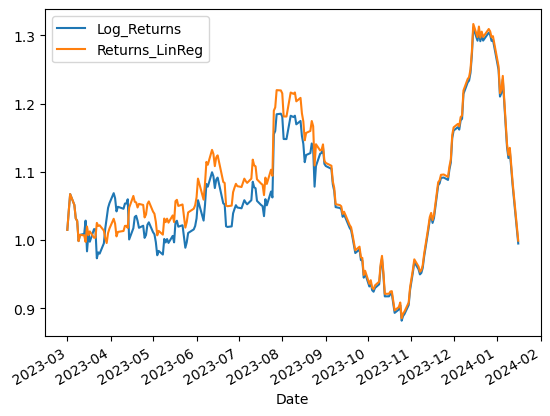

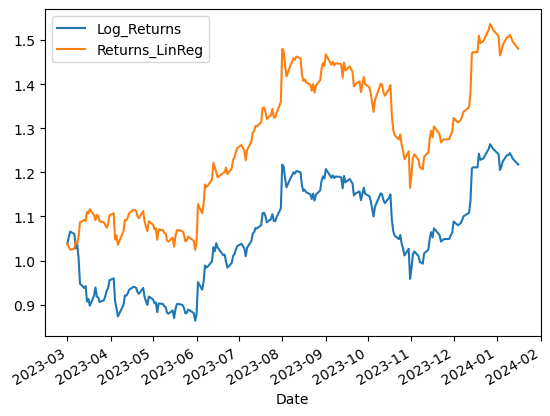

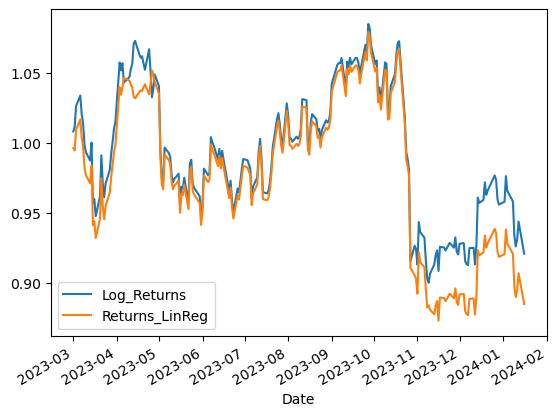

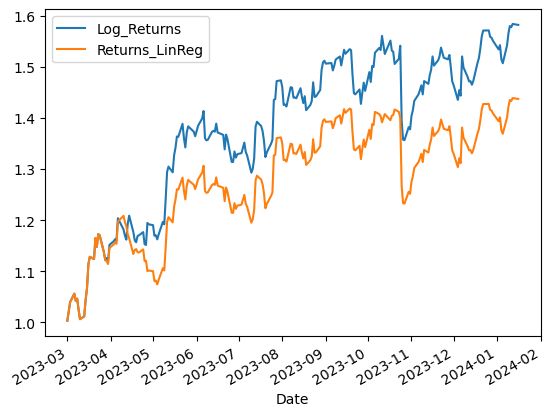

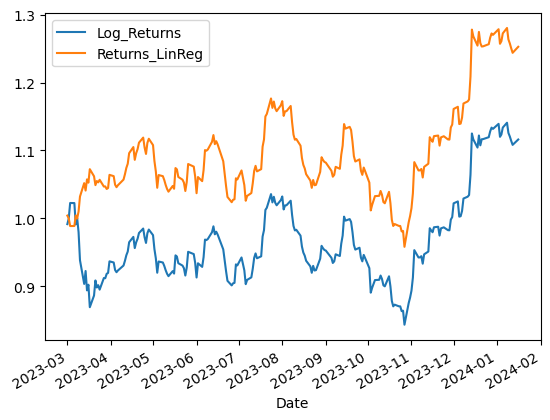

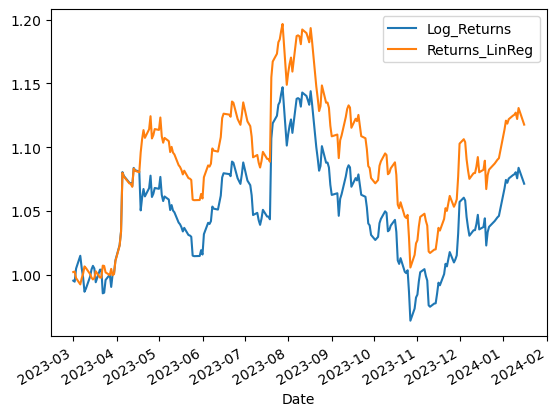

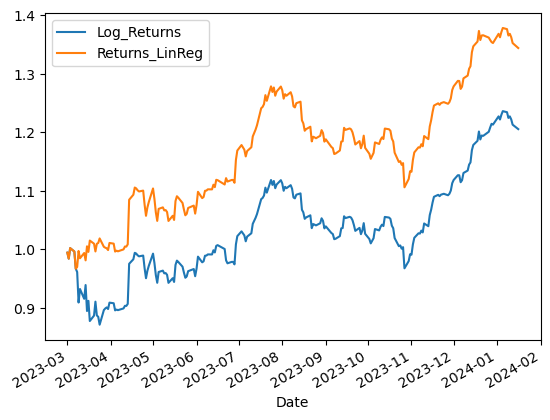

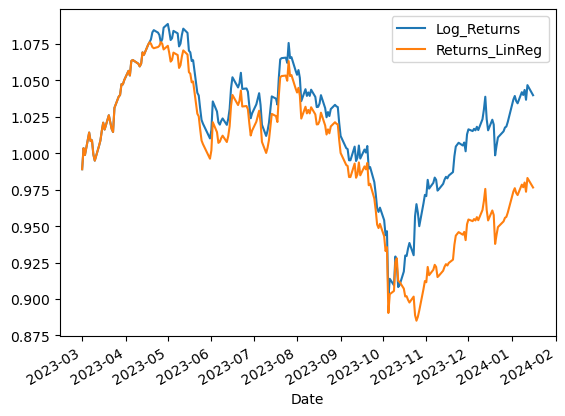

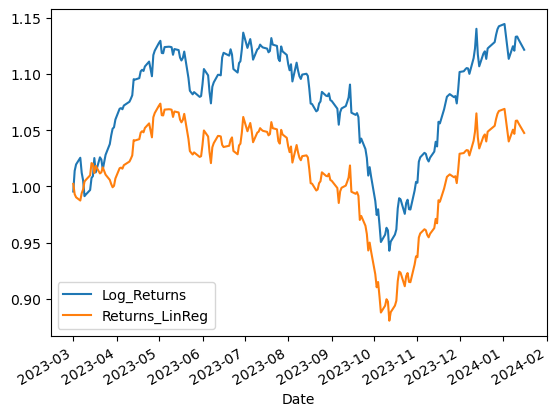

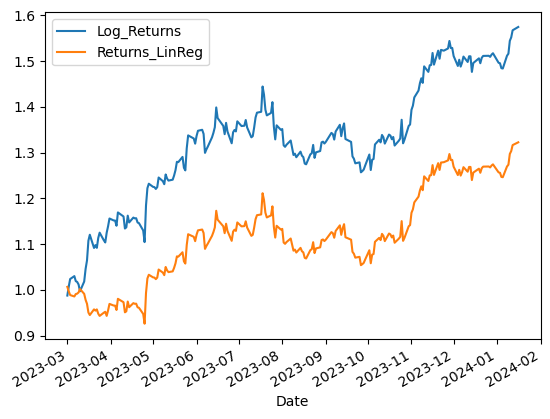

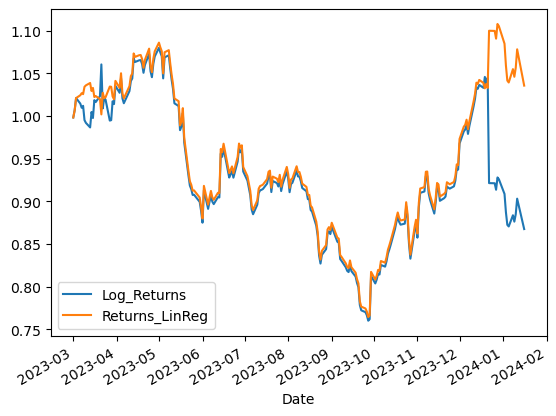

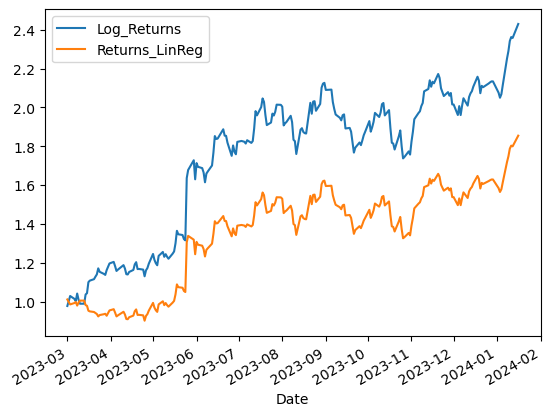

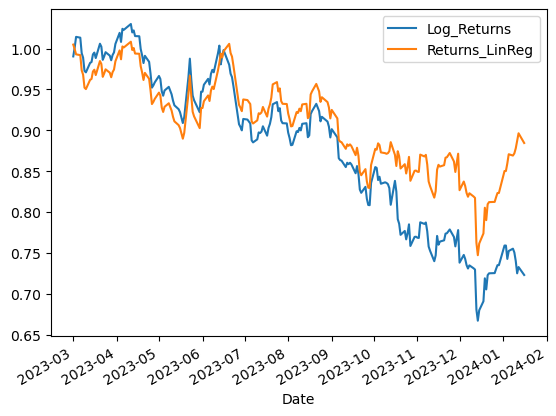

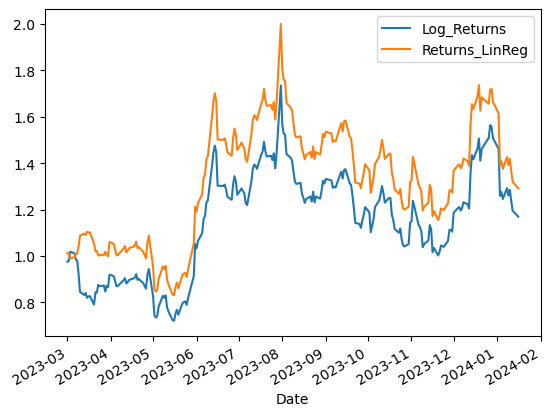

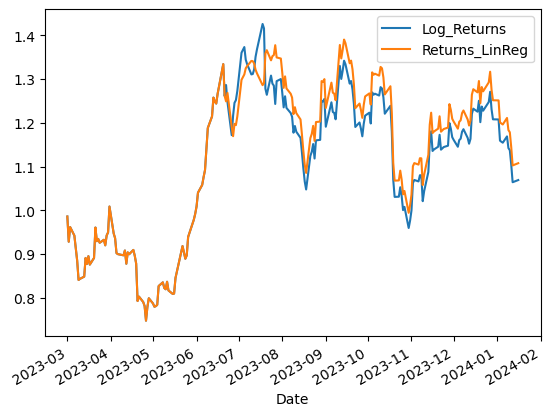

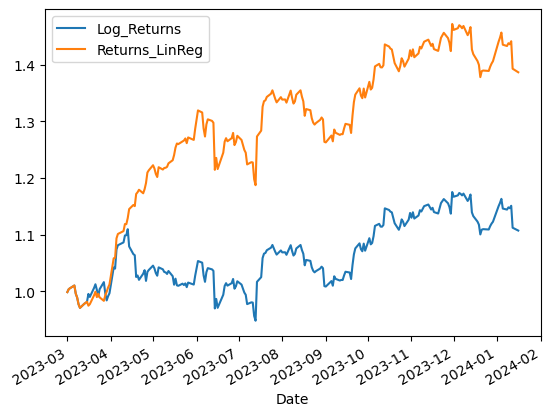

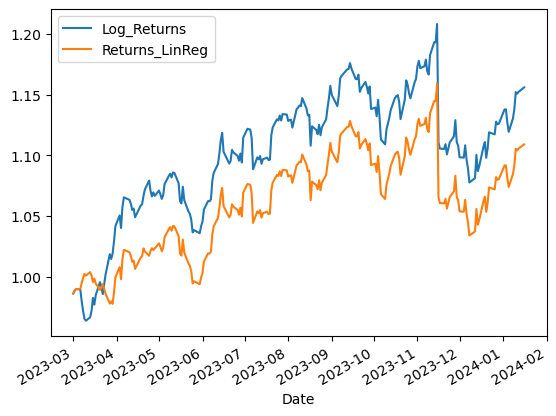

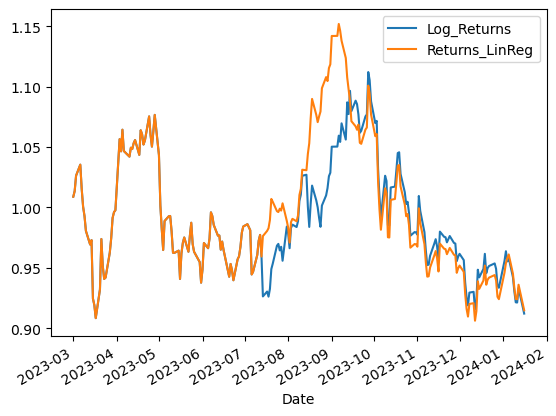

In [198]:
res_test, acc_res_test = get_results(test_data, test_vol, '2023-02-28', '2023-03-01', sliding_window_linear_reg, features)

## trading window

In [200]:
data1 = clean_data(file).iloc[:, :20].copy() # extract close prices from cleaned data
stocks = list(set([col.split("_")[0] for col in data1.columns]))
stocks.sort()
for stock in stocks:
    data1.rename(columns={f'{stock}_Close': f'{stock}'}, inplace=True)

AAPL
Log_Returns       1.267419
Returns_LinReg    1.366697
dtype: float64


AMZN
Log_Returns       1.248359
Returns_LinReg    1.178650
dtype: float64


BA
Log_Returns       0.829226
Returns_LinReg    1.050145
dtype: float64


CAT
Log_Returns       1.152445
Returns_LinReg    1.086898
dtype: float64


CVX
Log_Returns       1.081849
Returns_LinReg    0.988822
dtype: float64


GOOGL
Log_Returns       1.398305
Returns_LinReg    1.384640
dtype: float64


GS
Log_Returns       1.602419
Returns_LinReg    1.699558
dtype: float64


JNJ
Log_Returns       0.937535
Returns_LinReg    1.011657
dtype: float64


JPM
Log_Returns       1.397843
Returns_LinReg    1.383673
dtype: float64


KO
Log_Returns       1.068831
Returns_LinReg    1.054340
dtype: float64


MCD
Log_Returns       0.974744
Returns_LinReg    0.949619
dtype: float64


MSFT
Log_Returns       1.032215
Returns_LinReg    1.100377
dtype: float64


NKE
Log_Returns       0.695947
Returns_LinReg    0.598209
dtype: float64


NVDA
Log_Returns       

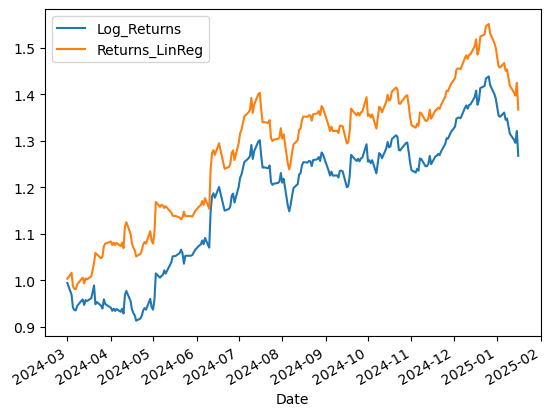

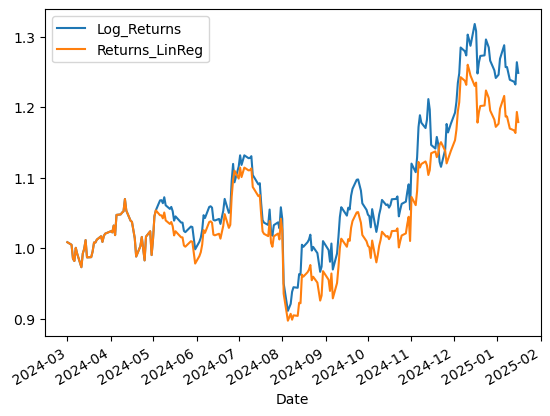

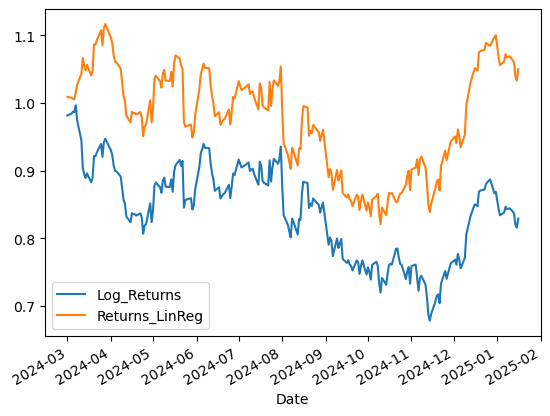

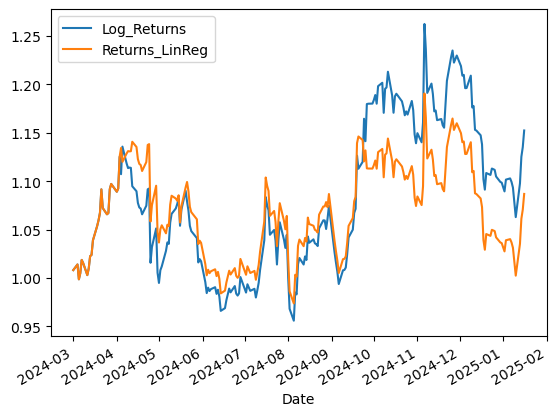

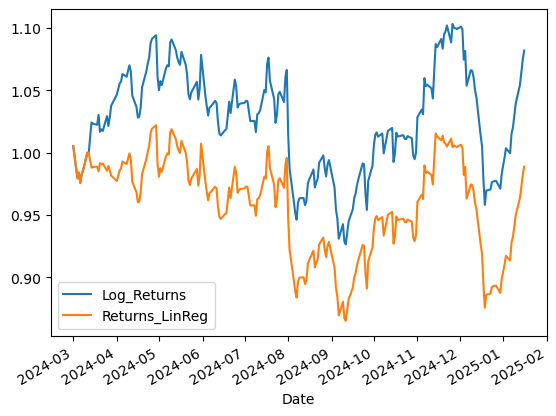

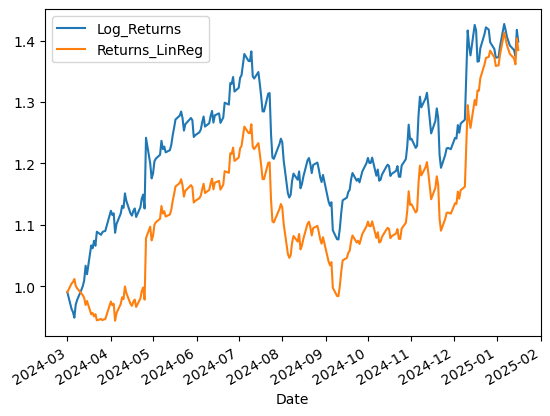

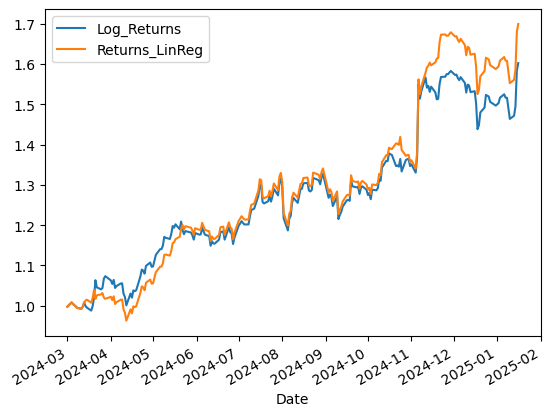

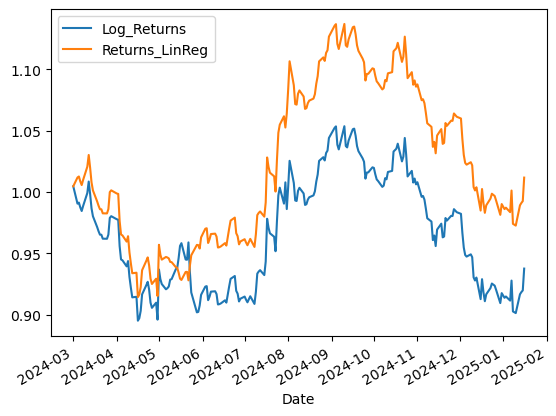

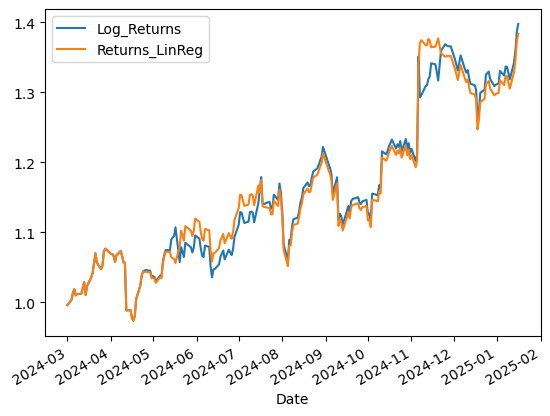

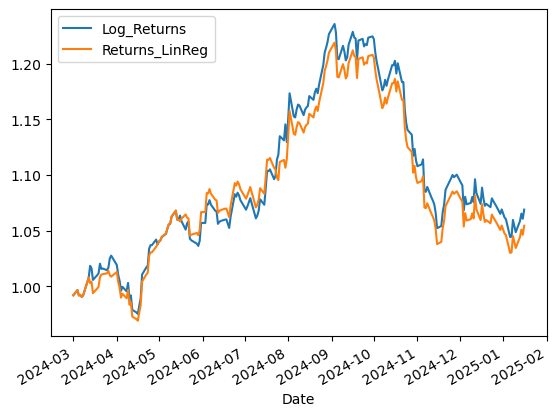

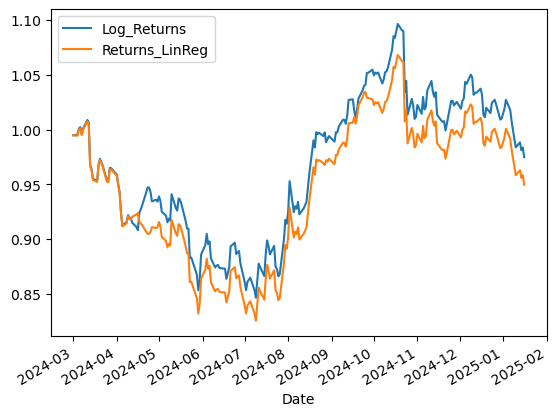

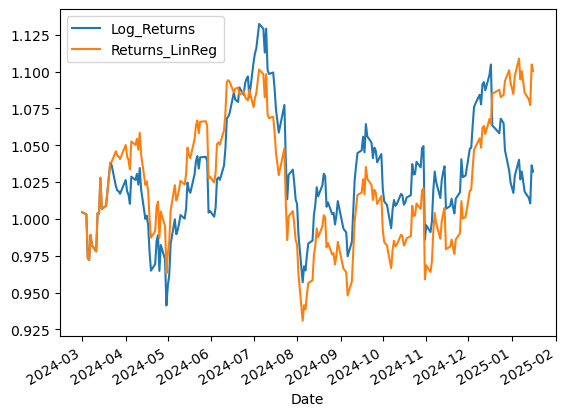

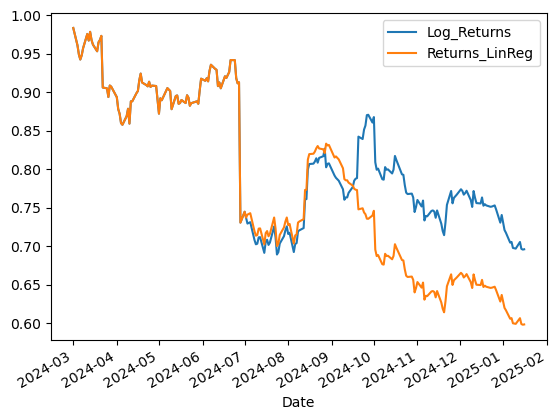

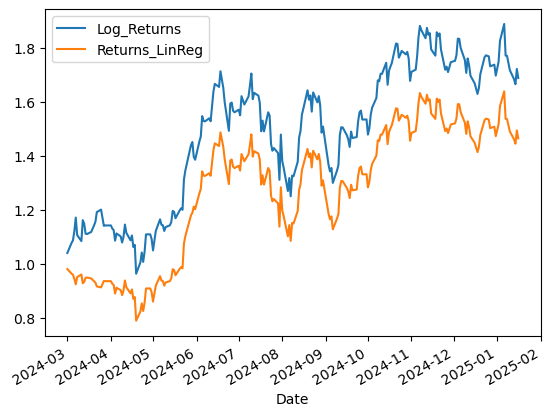

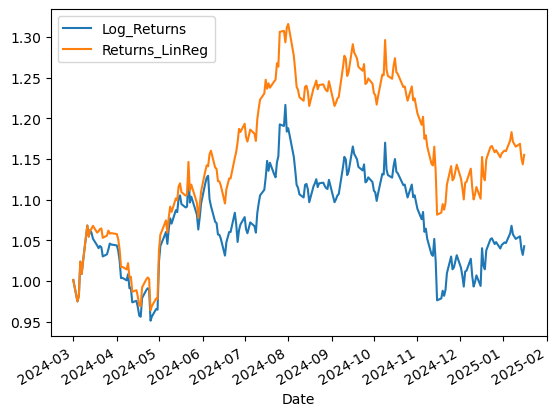

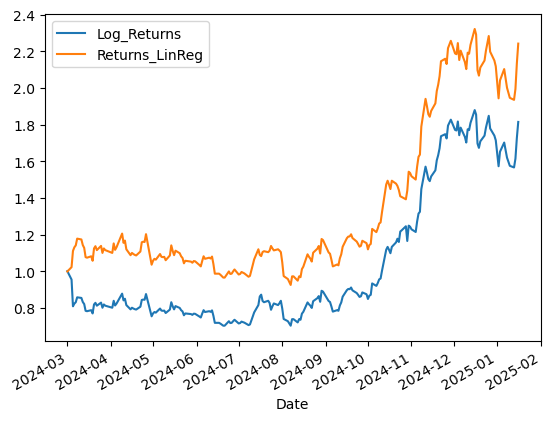

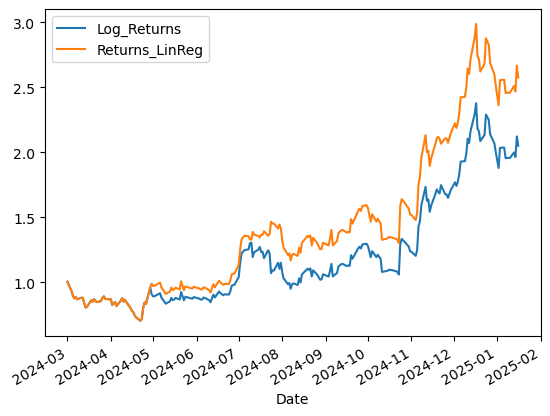

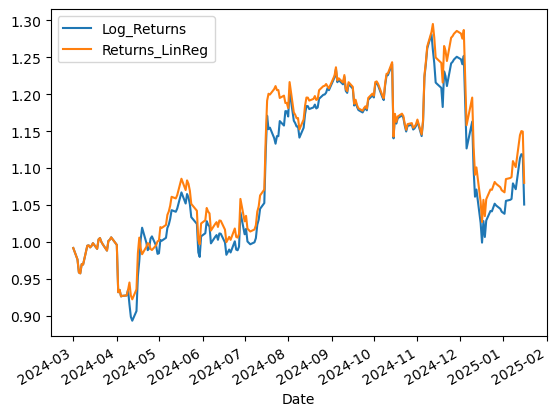

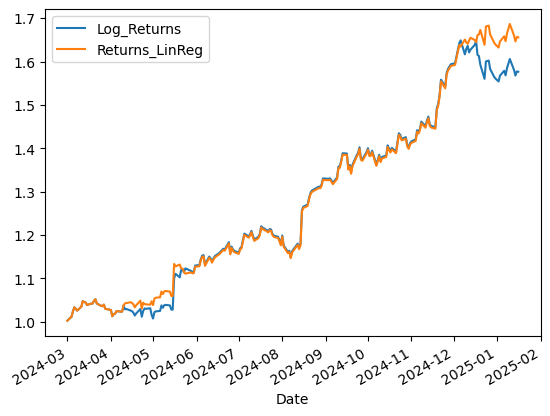

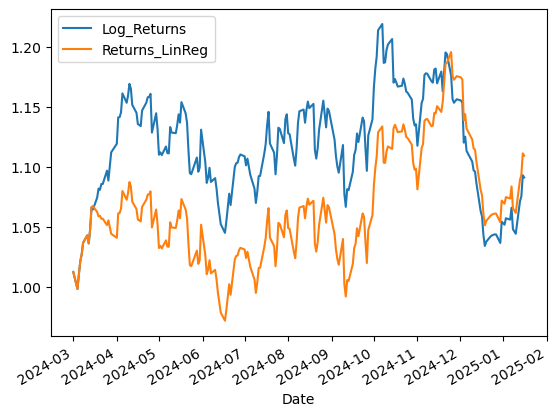

In [201]:
res, acc_res = get_results(data1, volume, '2024-02-29', '2024-03-01', sliding_window_linear_reg, features)

## portfolio optimisation (mvo, maximise sharpe ratio)

In [206]:
def mvo(returns_df, rf=0.04): # using test returns, allowed short selling, max leverage = 2
    
    # calculate expected annualized returns for each stock
    expected_returns = np.mean((np.exp(returns_df) - 1), axis=0) * 252

    # calculate the annualized covariance matrix of returns
    cov_matrix = returns_df.cov() * 252

    # objective function (to minimise negative sharpe ratio)
    def objective(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - rf) / portfolio_volatility
        return -sharpe_ratio

    # initial guess (equal weights)
    num_assets = 9 # treat the pair as one asset
    init_guess = num_assets * [1. / num_assets]

    # constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
                  {'type': 'ineq', 'fun': lambda weights: 2 - np.sum(np.abs(weights))})  # max leverage = 2 -> total exposure (long + short positions) of the portfolio cannot exceed 200% of the portfolio’s capital

    # optimization using Sequential Least Squares Quadratic Programming (SLSQP)
    result = minimize(objective, init_guess, method='SLSQP', constraints=constraints)

    if not result.success:
        raise BaseException(result.message)

    optimal_weights = result.x
    max_sharpe_ratio = -result.fun

    # Store the optimal weights in a DataFrame
    optimal_weights_df = pd.DataFrame(optimal_weights, index=returns_df.columns, columns=['Optimal Weights'])

    return optimal_weights, optimal_weights_df, max_sharpe_ratio


def calculate_sharpe_ratio(returns_df, rf = 0.04):
    expected_returns = np.mean((np.exp(returns_df) - 1), axis=0) * 252 # annualised
    cov_matrix = returns_df.cov() * 252 # annualised
    portfolio_return = np.dot(optimal_weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
    sharpe_ratio = (portfolio_return - rf) / portfolio_volatility
    return sharpe_ratio

'''
def calculate_final_portfolio_value(returns_df, optimal_weights, initial_capital=50000):
    weights = pd.Series(optimal_weights)
    
    # calculate portfolio log returns by taking the weighted sum of individual stock returns
    # portfolio_returns = (returns_df * weights).sum(axis=1)
    portfolio_returns = (returns_df * weights.values).sum(axis=1)
    
    # calculate cumulative simple return (1+R)
    cumulative_returns = np.exp(portfolio_returns.cumsum())

    cumulative_wealth = initial_capital * cumulative_returns
    final_port_value = cumulative_wealth.iloc[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_wealth)
    plt.title('Cumulative wealth')
    plt.xlabel('Time (Trading Period)')
    plt.ylabel('Capital')
    
    return final_port_value
'''

"\ndef calculate_final_portfolio_value(returns_df, optimal_weights, initial_capital=50000):\n    weights = pd.Series(optimal_weights)\n    \n    # calculate portfolio log returns by taking the weighted sum of individual stock returns\n    # portfolio_returns = (returns_df * weights).sum(axis=1)\n    portfolio_returns = (returns_df * weights.values).sum(axis=1)\n    \n    # calculate cumulative simple return (1+R)\n    cumulative_returns = np.exp(portfolio_returns.cumsum())\n\n    cumulative_wealth = initial_capital * cumulative_returns\n    final_port_value = cumulative_wealth.iloc[-1]\n\n    plt.figure(figsize=(10, 6))\n    plt.plot(cumulative_wealth)\n    plt.title('Cumulative wealth')\n    plt.xlabel('Time (Trading Period)')\n    plt.ylabel('Capital')\n    \n    return final_port_value\n"

In [208]:
def calculate_final_portfolio_value(returns_df, weights, initial_capital=50000):
    weights = pd.Series(weights)
    
    # calculate portfolio log returns by taking the weighted sum of individual stock returns
    portfolio_returns = (returns_df * weights.values).sum(axis=1)
    
    # calculate cumulative simple return (1+R)
    cumulative_returns = np.exp(portfolio_returns.cumsum())

    cumulative_wealth = initial_capital * cumulative_returns
    final_port_value = cumulative_wealth.iloc[-1]
    
    return final_port_value, cumulative_wealth

### stocks returns in portfolio

In [220]:
port_stocks = ['GS', 'UNH', 'TSLA', ('BA', 'XOM'), 'MCD', 'NKE', 'MSFT', 'JNJ', 'SOFI', ('MCD', 'XOM')]
port_SMA = ['JNJ', 'SOFI']# SMA stocks
port_MACD = ['MCD', 'NKE', 'MSFT'] # MACD stocks
port_pairs = [('BA', 'XOM'), ('MCD', 'XOM')] # pairs stocks
# port_bollinger = [] # bollinger stocks
# linear regression stocks
port_LR = ['GS', 'SOFI', 'TSLA']

test_returns_df = pd.DataFrame(index = test_data.index, columns = port_stocks)
returns_df = pd.DataFrame(index = data.index, columns = port_stocks)

In [222]:
for pair in port_pairs:
    pair_params = test_pairs_all_best_params[pair] # optimised params
    best_entry, best_exit, best_window = pair_params['best_entry'], pair_params['best_exit'], pair_params['best_window']

    _, test_pair_df = pairs_strat(test_data, pair, best_window, best_entry, best_exit)
    test_returns_df[pair] = test_pair_df['combined_returns']
    test_returns_df[pair] = test_returns_df[pair].fillna(0)

    _, pair_df = pairs_strat(data, pair, best_window, best_entry, best_exit)
    returns_df[pair] = pair_df['combined_returns']
    returns_df[pair] = returns_df[pair].fillna(0)

for stock in port_SMA:
    sma_params = test_sma_all_best_params[stock]
    best_short, best_long = sma_params['best_short'], sma_params['best_long']
    _, test_stock_df = sma_strat(test_data, stock, best_short, best_long)
    test_returns_df[stock] = test_stock_df['SMA_Returns']
    test_returns_df[stock] = test_returns_df[stock].fillna(0)

    _, stock_df = sma_strat(data, stock, best_short, best_long)
    returns_df[stock] = stock_df['SMA_Returns']
    returns_df[stock] = returns_df[stock].fillna(0)
'''
for stock in port_bollinger:
    boll_params = test_bollinger_all_best_params[stock]
    best_std, best_window = boll_params['best_std'], sma_params['best_window']
    _, test_stock_df = bollinger_bands_strat(test_data, stock, best_std, best_window)
    test_returns_df[stock] = test_stock_df['Strat_Returns']
    test_returns_df[stock] = test_returns_df[stock].fillna(0)

    _, stock_df = bollinger_bands_strat(data, stock, best_std, best_window)
    returns_df[stock] = stock_df['Strat_Returns']
    returns_df[stock] = returns_df[stock].fillna(0)

'''

for stock in port_LR:
    test_returns_df[stock] = res_test[stock]
    test_returns_df[stock] = res_test[stock].fillna(0)
    
    returns_df[stock] = res[stock]
    returns_df[stock] = res[stock].fillna(0)

# Optimised weights based on past returns

In [227]:
test_returns_df

,GS,UNH,TSLA,"(BA, XOM)",MCD,NKE,MSFT,JNJ,SOFI,"(MCD, XOM)"
Date,,,,,,,,,,
2023-01-17,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,0.000000
2023-01-18,NaN,NaN,NaN,-0.000000,NaN,NaN,NaN,-0.000000,NaN,-0.000000
2023-01-19,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,-0.000000,NaN,0.000000
2023-01-20,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,-0.000000,NaN,0.000000
2023-01-23,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,-0.000000,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...
2024-01-09,-0.013254,NaN,-0.023097,-0.008018,NaN,NaN,NaN,0.000619,-0.024927,0.002697
2024-01-10,-0.004649,NaN,-0.004351,0.014112,NaN,NaN,NaN,0.001484,0.019048,0.015950
2024-01-11,-0.005803,NaN,-0.029146,-0.022896,NaN,NaN,NaN,-0.004458,-0.037241,0.000305


In [229]:
print(test_returns_df.dtypes)

GS            float64
UNH            object
TSLA          float64
(BA, XOM)     float64
MCD            object
NKE            object
MSFT           object
JNJ           float64
SOFI          float64
(MCD, XOM)    float64
dtype: object


In [225]:
optimal_weights, optimal_weights_df, max_sharpe_ratio = mvo(test_returns_df, rf=0.04)
print(f'sharpe ratio: {max_sharpe_ratio}') # on test data
optimal_weights_df

TypeError: loop of ufunc does not support argument 0 of type float which has no callable exp method

In [218]:
final_port_value, optimised_weight_cumulative = calculate_final_portfolio_value(test_returns_df, optimal_weights, initial_capital=50000)
print(f'Final Portfolio Value: ${final_port_value:.2f}')
print(f"Portfolio's Sharpe Ratio: {calculate_sharpe_ratio(returns_df):.4f}") # sharpe ratio on trading data

Final Portfolio Value: $63656.37
Portfolio's Sharpe Ratio: 0.8711


In [107]:
optimised_weight_cumulative

Date
2024-03-01    49996.347958
2024-03-04    50054.044480
2024-03-05    50145.672826
2024-03-06    50169.083344
2024-03-07    50171.490683
                  ...     
2025-01-10    53979.356169
2025-01-13    54053.797086
2025-01-14    54418.894013
2025-01-15    54749.825807
2025-01-16    54734.629131
Length: 221, dtype: float64

# benchmark strat

In [120]:
benchmark_port_stocks = ['GS', 'UNH', 'TSLA', 'BA', 'XOM', 'MCD', 'NKE', 'MSFT', 'JNJ', 'SOFI']
port_stocks = ['GS', 'UNH', 'TSLA', ('BA', 'XOM'), 'MCD', 'NKE', 'MSFT', 'JNJ', 'SOFI', ('MCD', 'XOM')]
port_SMA = ['JNJ', 'SOFI'] # SMA stocks
port_MACD = ['MCD', 'NKE', 'MSFT'] # MACD stocks
port_pairs = [('BA', 'XOM'), ('MCD', 'XOM')] # pairs stocks
port_LR = ['GS', 'UNH', 'TSLA'] # linear regression stocks

test_returns_df = pd.DataFrame(index = test_data.index, columns = port_stocks)
returns_df = pd.DataFrame(index = data.index, columns = port_stocks)
benchmark_returns_df = pd.DataFrame(index = data.index, columns = benchmark_port_stocks)

In [122]:
for stock in benchmark_port_stocks:
    _, df = benchmark_strategy(data, stock, rf = 0.04)
    benchmark_returns_df[stock] = df['Returns']
    benchmark_returns_df[stock] = benchmark_returns_df[stock].fillna(0)

In [128]:
num_assets = 10
benchmark_weights = np.array(num_assets * [1. / num_assets]) # equal weight allocation

final_benchmark_port_value, benchmark_cumulative_wealth = calculate_final_portfolio_value(benchmark_returns_df, benchmark_weights, initial_capital=50000)
#benchmark_port_sharpe = calculate_sharpe_ratio(benchmark_returns_df)
benchmark_cumulative_wealth

Date
2024-03-01    50000.000000
2024-03-04    49130.062659
2024-03-05    47924.394902
2024-03-06    47869.848157
2024-03-07    48162.382711
                  ...     
2025-01-10    55317.484483
2025-01-13    55908.548926
2025-01-14    55874.242142
2025-01-15    57241.147595
2025-01-16    57160.283947
Length: 221, dtype: float64

<Axes: xlabel='Date'>

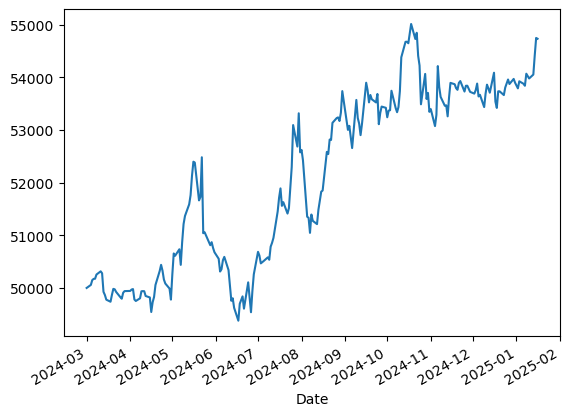

In [132]:
optimised_weight_cumulative.plot()

# Plot on Trading Period

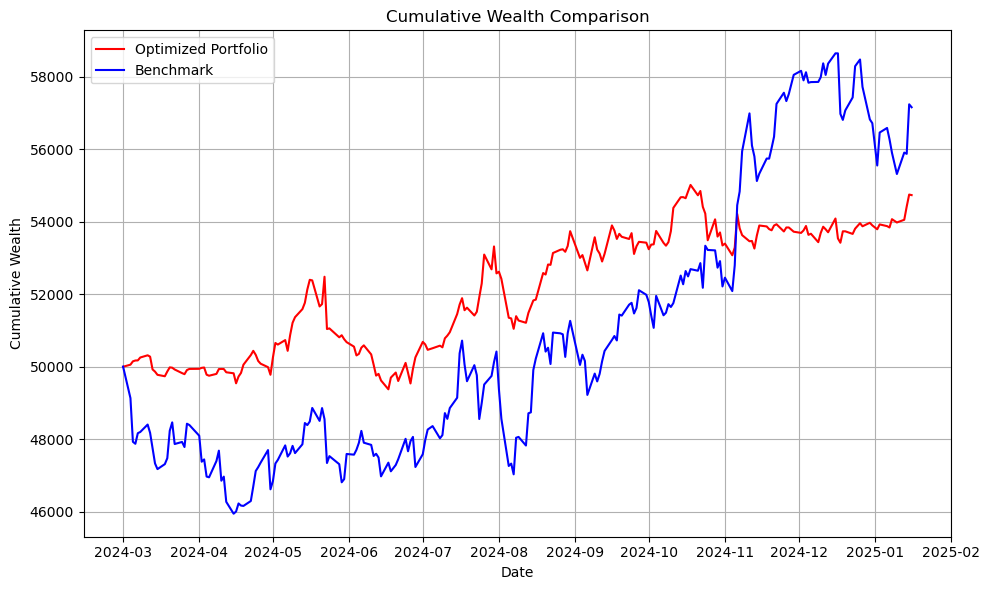

In [151]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot optimized portfolio cumulative returns
ax1.plot(optimised_weight_cumulative, label='Optimized Portfolio', color='red')

# Plot benchmark cumulative returns
ax1.plot(benchmark_cumulative_wealth, label='Benchmark', color='blue')

# Set labels and title
ax1.set_title('Cumulative Wealth Comparison')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Wealth')
ax1.grid(True)

# Show legend
ax1.legend()

# Display plot
plt.tight_layout()
plt.show()


# Plot on Testing Period

In [159]:
test_data = test.history(start = '2023-01-17', end = '2024-01-17')

[*********************100%***********************]  20 of 20 completed
